In [160]:
import pandas as pd
from data_creation import get_rfm_data
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import squarify

In [161]:
df = pd.read_parquet("wallet_urfu.parquet.gzip")
full_df = pd.DataFrame()

In [162]:
df.shape

(52032799, 3)

In [163]:
df["rep_date"].min()

datetime.date(2016, 1, 2)

In [164]:
df["rep_date"].max()

datetime.date(2023, 2, 23)

In [165]:
min_year = df["rep_date"].min().year
max_year = df["rep_date"].max().year

In [192]:
def create_score(df):
    df["Recency_Score"]  = pd.qcut(df['recency'].rank(method='first'), 5, [5, 4, 3, 2, 1])
    df["Frequency_Score"]  = pd.qcut(df['frequency'].rank(method="first"), 5, [1, 2, 3, 4, 5])
    df["Monetary_Score"]  = pd.qcut(df['monetary_value'].rank(method='first'), 5, [1, 2, 3, 4, 5])
    df["RFM_SCORE"] = (df['Recency_Score'].astype(str) + df['Frequency_Score'].astype(str))
    df['Segment'] = df['RFM_SCORE']
    
    seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_Risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }
    df['Segment'] = df['Segment'].replace(seg_map, regex=True)
    df.reset_index(inplace=True)
    return df

In [195]:
def plot_pie(df):
    colors  = ("darkorange", "darkseagreen", "orange", "cyan", "cadetblue", "hotpink", "lightsteelblue", "coral",  "mediumaquamarine","palegoldenrod")
    
    df.plot.pie(subplots=True,colors=colors,
                    textprops={'fontsize': 12}, 
                    autopct = '%4.1f',
                    startangle= 90, 
                    radius =1, 
                    rotatelabels=True,
                    shadow = True)
    plt.show()

In [196]:
def plot_squarify(df):
    squarify.plot(sizes=df['partner'], 
              label=df['partner'].index, alpha=.6 )
    plt.title("RFM Segments",fontsize=18,fontweight="bold")
    plt.axis('off')
    plt.show()

In [200]:
def show_score(df, year, month):
    count_df = df.groupby('Segment').agg({"partner":"count"}).sort_values("partner",ascending=False)
    print(count_df)
    plot_pie(count_df)    
    plot_squarify(count_df)
    

2016 1
                     partner
Segment                     
cant_loose             30372
new_customers          30372
at_Risk                30371
need_attention         30371
potential_loyalists    30371


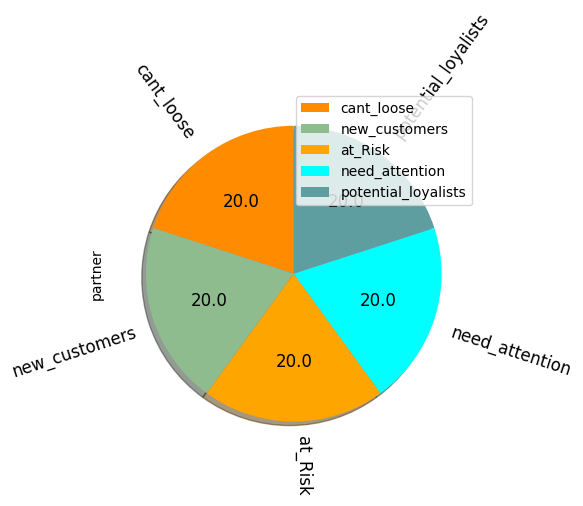

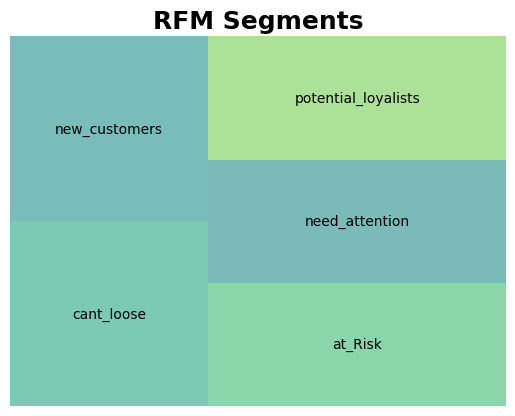

In [225]:
for year in range(min_year, min_year+1):
    for month in range(1, 2):
        df_rfm_alive, df_rfm_dead = get_rfm_data(year, month, 95, df)
        rfm_df = create_score(df_rfm_alive)
        rfm_df["year"] = year
        rfm_df["month"] = month
        print(year, month)
        show_score(rfm_df, year, month)

        #full_df = full_df.append(rfm_df)
        
        #if df_rfm_alive is not None:
        #    print(df_rfm_alive.shape)
        #if df_rfm_dead is not None:
        #    print(df_rfm_dead.shape)


In [202]:
full_df.head()

,partner,frequency,recency,T,monetary_value,Recency_Score,Frequency_Score,Monetary_Score,RFM_SCORE,Segment,year,month
0,0,0.0,0.0,4.0,0.000000e+00,5,1,1,51,new_customers,2016,1
1,1,2.0,12.0,16.0,7.595631e-11,1,5,5,15,cant_loose,2016,1
2,4,8.0,25.0,27.0,2.540538e-11,1,5,5,15,cant_loose,2016,1
3,6,0.0,0.0,10.0,0.000000e+00,5,1,1,51,new_customers,2016,1
4,9,0.0,0.0,13.0,0.000000e+00,5,1,1,51,new_customers,2016,1


month
1     303714
2     335128
3     410324
4     448975
5     452906
6     460674
7     476719
8     480254
9     484815
10    481035
11    490004
12    496248
Name: month, dtype: int64


KeyboardInterrupt: 

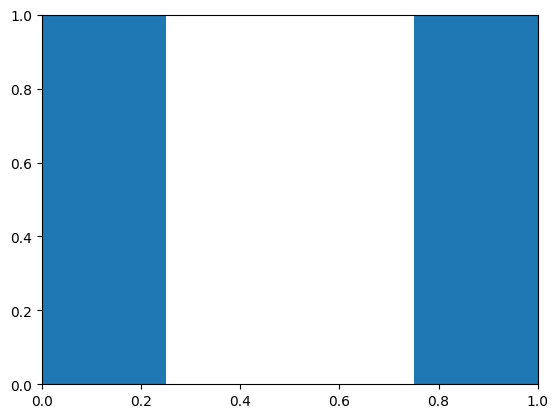

In [227]:
for year in range(min_year, max_year+1):
    cols = ['month','Segment']
    tmp_df = full_df[full_df['year'] == year]
    tmp_df = tmp_df[cols]
    print(tmp_df.groupby('month')['month'].count())
    w = 0.6

    tmp_df = tmp_df.reindex(['month','Segment'], axis=1)
    tmp_df.plot(stacked = True, kind="bar")
    plt.show()

In [187]:
full_df.head()
for year in range(min_year, max_year+1):
    cols = ['partner', 'Segment', 'year', 'month']
    saved_df = full_df[full_df['year'] == year]
    saved_df = saved_df[cols]
    saved_df.to_csv(str(year) + "rfm_by_time.csv")

In [182]:
saved_df

,partner,Segment,year,month
0,0,new_customers,2016,1
1,1,cant_loose,2016,1
2,4,cant_loose,2016,1
3,6,new_customers,2016,1
4,9,new_customers,2016,1
...,...,...,...,...
394398,1695371,new_customers,2023,4
394399,1695372,new_customers,2023,4
394400,1695373,new_customers,2023,4
394401,1695374,new_customers,2023,4


In [183]:
saved_df.to_csv("rfm_by_time.csv")